In [1]:
import aicspylibczi
import trackpy as tp
import matplotlib.pyplot as plt

In [2]:
# purple is 647 fib 200 (channel 0)
# green was gfp (parkin 488) (channel 2)
# mcherry 555, mitochondria (channel 1)
# pearson correlation coefficient
# parkin comes on mitochondria, so you should see increase then maybe fib 200 channel will also increase
# question which one moves more?

In [113]:
czi2 = 'Experiment-17614(15-1hrtimepase).czi'

In [114]:
czi_file2 = aicspylibczi.CziFile(czi2)
image_data2, metadata2 = czi_file.read_image()

In [118]:
image_data2.shape

(77, 3, 1, 1839, 1839)

In [115]:
metadata2

[('T', 77), ('C', 3), ('Z', 1), ('Y', 1839), ('X', 1839)]

In [3]:
czi_file_path = 'Experiment-17614(15-1hrtimepase)-Airyscan Processing-01.czi'

In [4]:
czi_file = aicspylibczi.CziFile(czi_file_path)
image_data, metadata = czi_file.read_image()

In [5]:
print("Image shape:", image_data.shape)

Image shape: (77, 3, 1, 1839, 1839)


# Initial Imaging

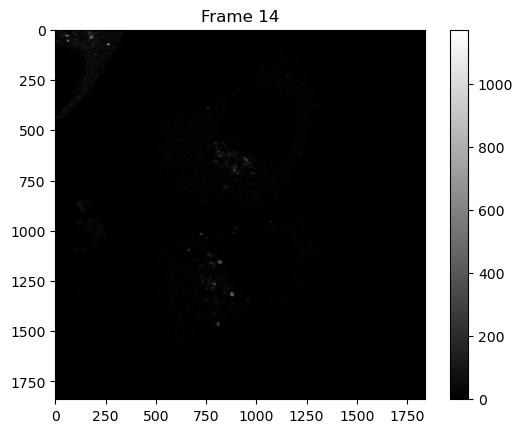

In [94]:
# this is fib 200
frame_index = 13
frame_to_display = image_data[frame_index, 0, 0, :, :]
plt.imshow(frame_to_display, cmap='gray')  # You can choose a different colormap if needed
plt.title(f'Frame {frame_index + 1}')
plt.colorbar()  # Add a colorbar for reference
plt.show()

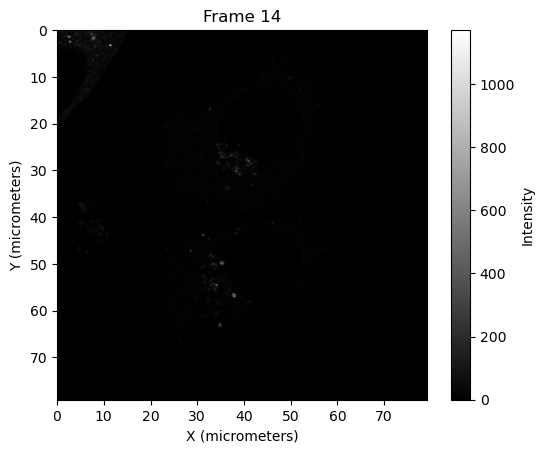

In [123]:
pixel_size_micrometers = 0.043

# Load your image data
frame_index = 13
frame_to_display = image_data[frame_index, 0, 0, :, :]

# Calculate the total physical dimensions of the image
total_physical_width = frame_to_display.shape[1] * pixel_size_micrometers
total_physical_height = frame_to_display.shape[0] * pixel_size_micrometers

# Plot the image with micrometer scale on axes
plt.imshow(frame_to_display, cmap='gray', extent=(0, total_physical_width, total_physical_height, 0))
plt.title(f'Frame {frame_index + 1}')
plt.xlabel('X (micrometers)')
plt.ylabel('Y (micrometers)')
plt.colorbar(label='Intensity')
plt.show()

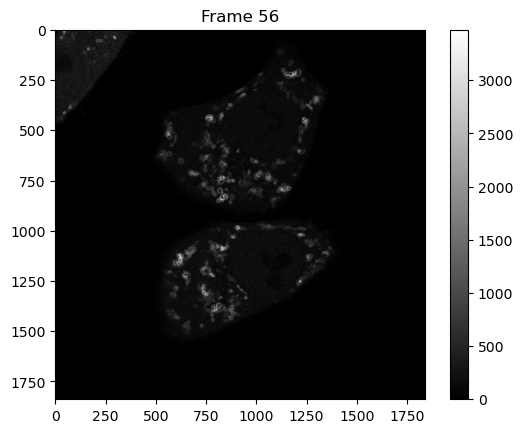

In [11]:
frame_index = 55
frame_to_display = image_data[frame_index, 2, 0, :, :]
plt.imshow(frame_to_display, cmap='gray')  # You can choose a different colormap if needed
plt.title(f'Frame {frame_index + 1}')
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [9]:
import cv2
import numpy as np
from tqdm import tqdm

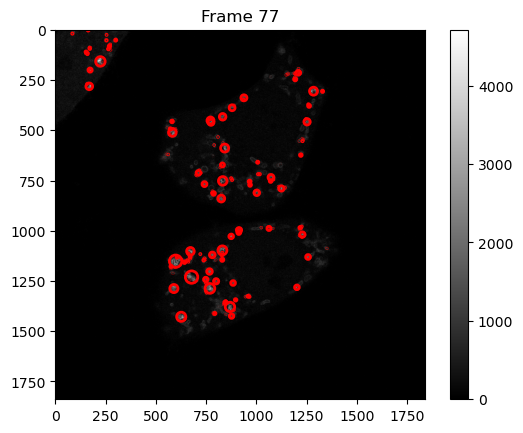

In [49]:
frame_index = 76

frame_to_display = image_data[frame_index, 2, 0, :, :]
threshold_value = 1200  
binary_image = (frame_to_display > threshold_value).astype(np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(frame_to_display, cmap='gray')
plt.title(f'Frame {frame_index + 1}')
plt.colorbar()
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    roi_circle = plt.Circle((x, y), radius, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(roi_circle)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


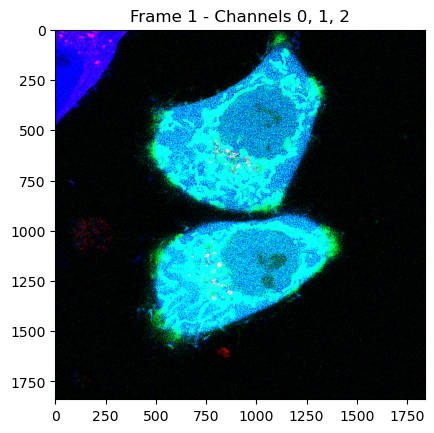

In [43]:
frame_index = 0

channel_0 = image_data[frame_index, 0, 0, :, :]
channel_1 = image_data[frame_index, 1, 0, :, :]
channel_2 = image_data[frame_index, 2, 0, :, :]

rgb_image = np.stack([channel_0, channel_1, channel_2], axis=-1)

plt.imshow(rgb_image)
plt.title(f'Frame {frame_index + 1} - Channels 0, 1, 2')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


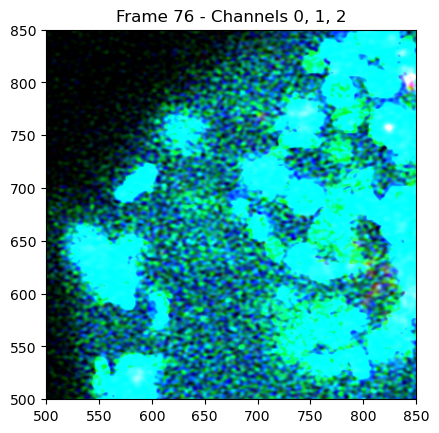

In [50]:
frame_index = 75

channel_0 = image_data[frame_index, 0, 0, :, :]
channel_1 = image_data[frame_index, 1, 0, :, :]
channel_2 = image_data[frame_index, 2, 0, :, :]

rgb_image = np.stack([channel_0, channel_1, channel_2], axis=-1)

plt.imshow(rgb_image)
plt.title(f'Frame {frame_index + 1} - Channels 0, 1, 2')
plt.xlim(500, 850)
plt.ylim(500, 850)
plt.show()

# how far do they move

In [125]:
# Define physical dimensions and number of pixels
physical_width_micrometers = 78.21
physical_height_micrometers = 78.21
image_width_pixels = 1839
image_height_pixels = 1839

# Calculate pixel size
pixel_size_x = physical_width_micrometers / image_width_pixels
pixel_size_y = physical_height_micrometers / image_height_pixels

In [158]:
def calculate_distance(point1, point2):
    distance_x = (point1[0] - point2[0]) * pixel_size_x
    distance_y = (point1[1] - point2[1]) * pixel_size_y
    return np.sqrt(distance_x**2 + distance_y**2)

frame_positions = []

for frame_index in range(76): 
    frame_to_display = image_data[frame_index, 2, 0, :, :]
    threshold_value = 650  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        x_physical = x * pixel_size_x
        y_physical = y * pixel_size_y
        frame_center_positions.append((x_physical, y_physical))

    frame_positions.append(frame_center_positions)

first_frame_centers = frame_positions[0]
last_frame_centers = frame_positions[-1]

matched_rois = []

for i, first_center in enumerate(first_frame_centers):
    min_distance = float('inf')
    matching_roi = None

    for j, last_center in enumerate(last_frame_centers):
        distance = calculate_distance(first_center, last_center)

        if distance < min_distance:
            min_distance = distance
            matching_roi = j
    matched_rois.append((i, matching_roi, min_distance))

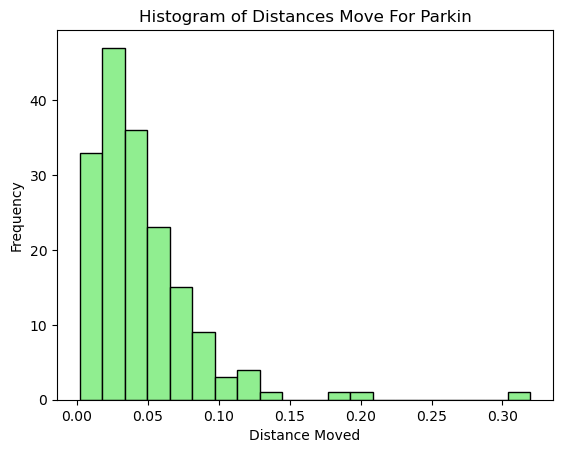

In [159]:
distances_moved = [distance for _, _, distance in matched_rois]
plt.hist(distances_moved, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Distances Move For Parkin')
plt.xlabel('Distance Moved')
plt.ylabel('Frequency')
plt.show()

In [23]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

frame_positions = []

In [27]:
for frame_index in range(76): 
    frame_to_display = image_data[frame_index, 1, 0, :, :]
    threshold_value = 1200  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        frame_center_positions.append((x, y))

    frame_positions.append(frame_center_positions)

In [ ]:
# mitochondria
first_frame_centers = frame_positions[0]
last_frame_centers = frame_positions[-1]
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
matched_rois = []

for i, first_center in enumerate(first_frame_centers):
    min_distance = float('inf')
    matching_roi = None

    for j, last_center in enumerate(last_frame_centers):
        distance = calculate_distance(first_center, last_center)

        if distance < min_distance:
            min_distance = distance
            matching_roi = j
    matched_rois.append((i, matching_roi, distance))
for first_roi, last_roi, distance_moved in matched_rois:
    print(f"ROI {first_roi + 1} - {last_roi + 1}.")
    print(f"Distance moved: {distance_moved}")

In [50]:
# this is parkin
for frame_index in range(76): 
    frame_to_display = image_data[frame_index, 2, 0, :, :]
    threshold_value = 1200  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        frame_center_positions.append((x, y))

    frame_positions.append(frame_center_positions)

In [51]:
first_frame_centers = frame_positions[0]
last_frame_centers = frame_positions[-1]
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
matched_rois = []

for i, first_center in enumerate(first_frame_centers):
    min_distance = float('inf')
    matching_roi = None

    for j, last_center in enumerate(last_frame_centers):
        distance = calculate_distance(first_center, last_center)

        if distance < min_distance:
            min_distance = distance
            matching_roi = j
    matched_rois.append((i, matching_roi, distance))
for first_roi, last_roi, distance_moved in matched_rois:
    print(f"ROI {first_roi + 1} - {last_roi + 1}.")
    print(f"Distance moved: {distance_moved}")

ROI 1 - 1.
Distance moved: 1565.89694743939
ROI 2 - 6.
Distance moved: 1558.3889116648643
ROI 3 - 1.
Distance moved: 1537.4069890565738
ROI 4 - 7.
Distance moved: 1582.7783325532353
ROI 5 - 7.
Distance moved: 1586.0505981840554
ROI 6 - 6.
Distance moved: 1534.969869411123
ROI 7 - 1.
Distance moved: 1489.902345793173
ROI 8 - 7.
Distance moved: 1550.5449666720267
ROI 9 - 1.
Distance moved: 1486.787786513571
ROI 10 - 5.
Distance moved: 1592.5514905333516
ROI 11 - 5.
Distance moved: 1590.1190207025386
ROI 12 - 8.
Distance moved: 1583.7778411128247
ROI 13 - 1.
Distance moved: 1471.2709641666963
ROI 14 - 1.
Distance moved: 1460.5903772105305
ROI 15 - 1.
Distance moved: 1448.6027750905353
ROI 16 - 26.
Distance moved: 1571.104388638769
ROI 17 - 26.
Distance moved: 1598.4061592724172
ROI 18 - 26.
Distance moved: 1620.8591980055987
ROI 19 - 28.
Distance moved: 1457.7692718671224
ROI 20 - 26.
Distance moved: 1573.002168123508
ROI 21 - 30.
Distance moved: 1403.2223250473794
ROI 22 - 30.
Distance m

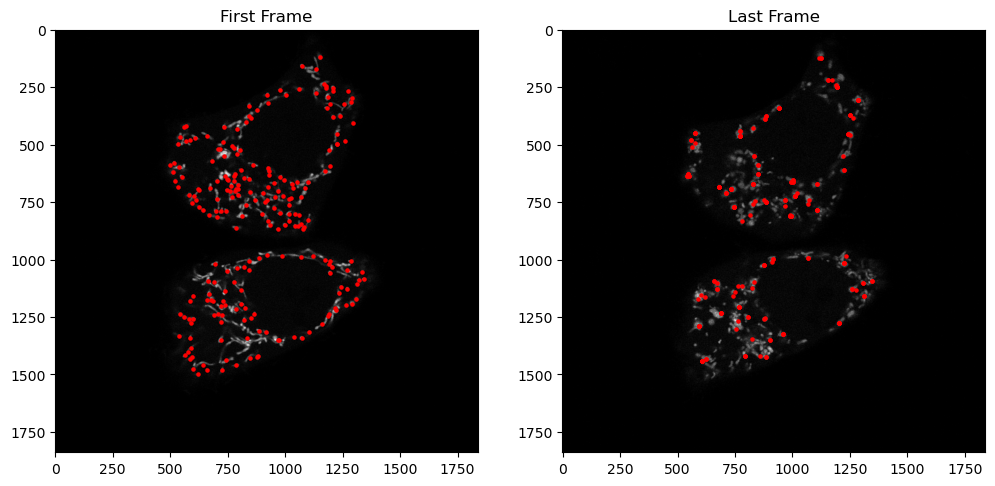

In [55]:
first_frame = image_data[0, 1, 0, :, :]
last_frame = image_data[-1, 1, 0, :, :]

plt.figure(figsize=(12, 6))

# Plot the first frame with ROIs
plt.subplot(1, 2, 1)
plt.imshow(first_frame, cmap='gray')
plt.title('First Frame')

for first_roi, _, _ in matched_rois:
    x, y = first_frame_centers[first_roi]
    plt.scatter(x, y, color='r', s=5)

# Plot the last frame with corresponding ROIs
plt.subplot(1, 2, 2)
plt.imshow(last_frame, cmap='gray')
plt.title('Last Frame')

for _, last_roi, _ in matched_rois:
    x, y = last_frame_centers[last_roi]
    plt.scatter(x, y, color='r', s=5)

plt.show()

In [57]:
from matplotlib.colors import hsv_to_rgb

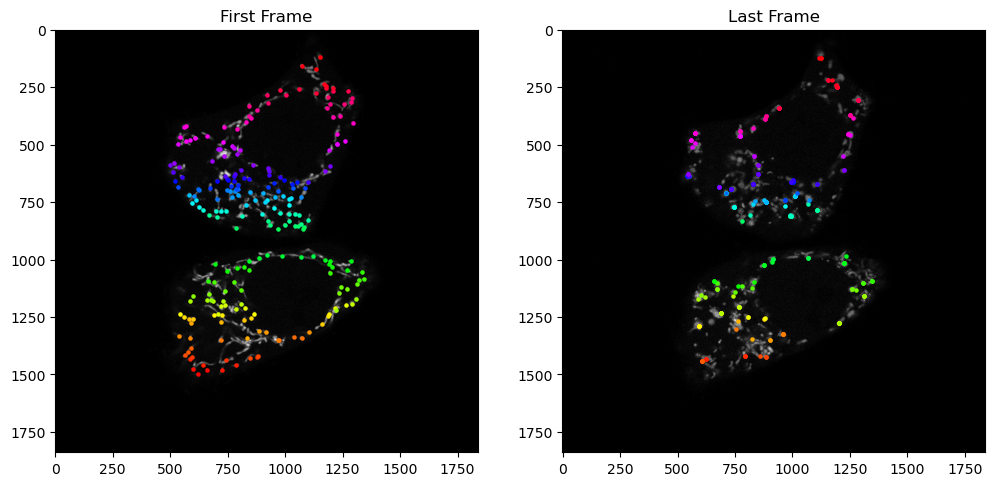

In [59]:
num_colors = len(matched_rois)
colors = [hsv_to_rgb([i / num_colors, 1, 1]) for i in range(num_colors)]

first_frame = image_data[0, 1, 0, :, :]
last_frame = image_data[-1, 1, 0, :, :]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(first_frame, cmap='gray')
plt.title('First Frame')

for (first_roi, _, _), color in zip(matched_rois, colors):
    x, y = first_frame_centers[first_roi]
    plt.scatter(x, y, color=color, s=5)

plt.subplot(1, 2, 2)
plt.imshow(last_frame, cmap='gray')
plt.title('Last Frame')

for (_, last_roi, _), color in zip(matched_rois, colors):
    x, y = last_frame_centers[last_roi]
    plt.scatter(x, y, color=color, s=5)

plt.show()

In [66]:
import random
from matplotlib.patches import Circle

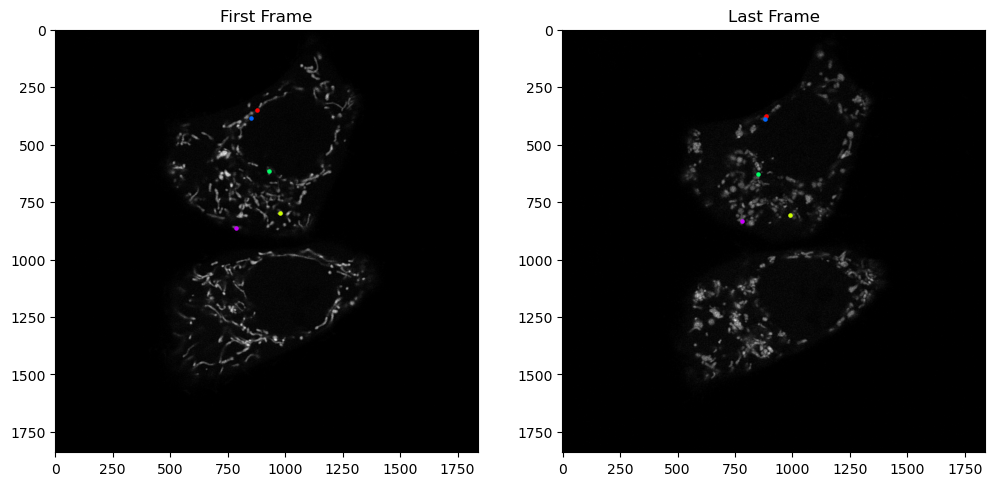

In [69]:
selected_rois = random.sample(matched_rois, min(5, len(matched_rois)))
num_colors = len(selected_rois)
colors = [hsv_to_rgb([i / num_colors, 1, 1]) for i in range(num_colors)]
first_frame = image_data[0, 1, 0, :, :]
last_frame = image_data[-1, 1, 0, :, :]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(first_frame, cmap='gray')
plt.title('First Frame')

for (first_roi, _, _), color in zip(selected_rois, colors):
    x, y = first_frame_centers[first_roi]
    plt.scatter(x, y, color=color, s=5)

# Plot the last frame with selected ROIs
plt.subplot(1, 2, 2)
plt.imshow(last_frame, cmap='gray')
plt.title('Last Frame')

for (_, last_roi, _), color in zip(selected_rois, colors):
    x, y = last_frame_centers[last_roi]
    plt.scatter(x, y, color=color, s=5)

plt.show()

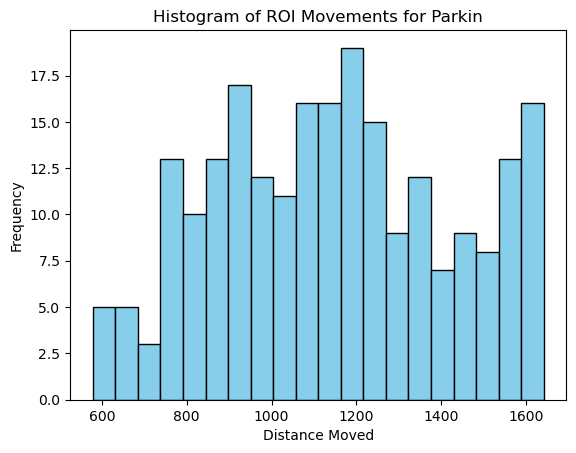

In [72]:
distances_moved = [distance for _, _, distance in matched_rois]
plt.hist(distances_moved, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ROI Movements for Parkin')
plt.xlabel('Distance Moved')
plt.ylabel('Frequency')
plt.show()

In [79]:
metadata

[('T', 77), ('C', 3), ('Z', 1), ('Y', 1839), ('X', 1839)]

In [84]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

frame_positions = []

for frame_index in range(77):  # Assuming you have frames from 0 to 76
    frame_to_display = image_data[frame_index, 1, 0, :, :]
    threshold_value = 1200  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        frame_center_positions.append((x, y))

    frame_positions.append(frame_center_positions)

# Calculate and display the movement
min_roi_count = min(len(frame_positions[i]) for i in range(76))

for roi_index in range(min_roi_count):
    movements = [calculate_distance(frame_positions[i][roi_index], frame_positions[i + 1][roi_index]) for i in range(75)]
    total_movement = sum(movements)
    print(f"ROI {roi_index + 1} total movement: {total_movement}")

ROI 1 total movement: 2654.1893217782736
ROI 2 total movement: 4269.019023273029
ROI 3 total movement: 5214.954335168611
ROI 4 total movement: 7497.786784489273
ROI 5 total movement: 8385.551087697788
ROI 6 total movement: 8518.127401740141
ROI 7 total movement: 9829.48444865152
ROI 8 total movement: 9992.666135511268
ROI 9 total movement: 9999.798415626512
ROI 10 total movement: 8535.788723514286
ROI 11 total movement: 10455.375177388103
ROI 12 total movement: 8812.385089200798
ROI 13 total movement: 9888.540997328948
ROI 14 total movement: 10402.425834598993
ROI 15 total movement: 9736.50361508013
ROI 16 total movement: 10796.995556907446
ROI 17 total movement: 8589.567089676333
ROI 18 total movement: 11558.471123730167
ROI 19 total movement: 9853.04917634204
ROI 20 total movement: 9859.912507859475
ROI 21 total movement: 15020.247705889822
ROI 22 total movement: 9274.872232865513
ROI 23 total movement: 12167.421088462115
ROI 24 total movement: 11672.109887198701
ROI 25 total movemen

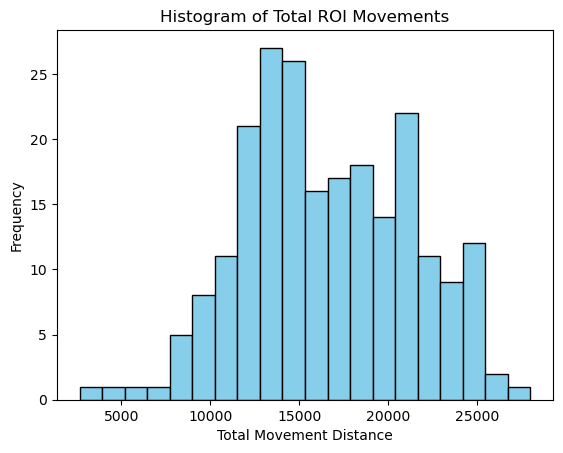

In [87]:
min_roi_count = min(len(frame_positions[i]) for i in range(76))
total_movements = [sum(calculate_distance(frame_positions[i][roi_index], frame_positions[i + 1][roi_index]) for i in range(75)) for roi_index in range(min_roi_count)]

# Plot the histogram
plt.hist(total_movements, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Total ROI Movements')
plt.xlabel('Total Movement Distance')
plt.ylabel('Frequency')
plt.show()

In [102]:
# this is fip 200
for frame_index in range(76): 
    frame_to_display = image_data[frame_index, 0, 0, :, :]
    threshold_value = 150  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        frame_center_positions.append((x, y))

    frame_positions.append(frame_center_positions)

In [103]:
first_frame_centers = frame_positions[0]
last_frame_centers = frame_positions[-1]

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

matched_rois = []

for i, first_center in enumerate(first_frame_centers):
    min_distance = float('inf')
    matching_roi = None

    for j, last_center in enumerate(last_frame_centers):
        distance = calculate_distance(first_center, last_center)

        if distance < min_distance:
            min_distance = distance
            matching_roi = j

    matched_rois.append((i, matching_roi, min_distance))

for first_roi, last_roi, distance_moved in matched_rois:
    print(f"ROI {first_roi + 1} - {last_roi + 1}.")
    print(f"Distance moved: {distance_moved}")


ROI 1 - 5.
Distance moved: 205.7790076757102
ROI 2 - 5.
Distance moved: 164.06172618865133
ROI 3 - 5.
Distance moved: 204.83163818121457
ROI 4 - 5.
Distance moved: 133.13526955694348
ROI 5 - 3.
Distance moved: 84.28671306914275
ROI 6 - 5.
Distance moved: 161.45665052886486
ROI 7 - 5.
Distance moved: 197.96274902112265
ROI 8 - 5.
Distance moved: 86.75754098665088
ROI 9 - 5.
Distance moved: 184.42651725164907
ROI 10 - 1.
Distance moved: 42.47940677551889
ROI 11 - 1.
Distance moved: 41.43971524998694
ROI 12 - 1.
Distance moved: 38.890872965260115
ROI 13 - 5.
Distance moved: 210.67629197420388
ROI 14 - 5.
Distance moved: 195.7268504830137
ROI 15 - 5.
Distance moved: 179.60860224387918
ROI 16 - 6.
Distance moved: 71.50174823037545
ROI 17 - 6.
Distance moved: 137.26343285813596
ROI 18 - 6.
Distance moved: 171.50320608045857
ROI 19 - 5.
Distance moved: 47.51841748206689
ROI 20 - 6.
Distance moved: 71.10866600645856
ROI 21 - 11.
Distance moved: 179.93215838677952
ROI 22 - 11.
Distance moved: 1

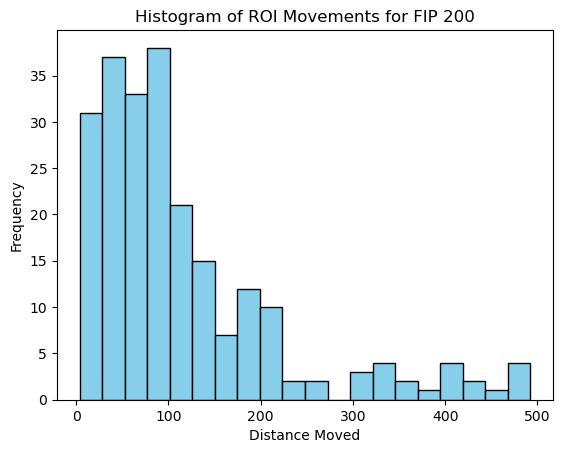

In [108]:
distances_moved = [distance for _, _, distance in matched_rois]
plt.hist(distances_moved, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ROI Movements for FIP 200')
plt.xlabel('Distance Moved')
plt.ylabel('Frequency')
plt.show()

In [109]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

frame_positions = []

for frame_index in range(77):  # Assuming you have frames from 0 to 76
    frame_to_display = image_data[frame_index, 0, 0, :, :]
    threshold_value = 150  
    binary_image = (frame_to_display > threshold_value).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_center_positions = []

    for contour in contours:
        (x, y), _ = cv2.minEnclosingCircle(contour)
        frame_center_positions.append((x, y))

    frame_positions.append(frame_center_positions)

# Calculate and display the movement
min_roi_count = min(len(frame_positions[i]) for i in range(76))

for roi_index in range(min_roi_count):
    movements = [calculate_distance(frame_positions[i][roi_index], frame_positions[i + 1][roi_index]) for i in range(75)]
    total_movement = sum(movements)
    print(f"ROI {roi_index + 1} total movement: {total_movement}")

ROI 1 total movement: 7099.571806369122
ROI 2 total movement: 4917.704460537137
ROI 3 total movement: 4984.357430619612
ROI 4 total movement: 5580.352926399708
ROI 5 total movement: 6262.87119364875
ROI 6 total movement: 4546.807165194244
ROI 7 total movement: 6001.591303859446
ROI 8 total movement: 5973.20437164009
ROI 9 total movement: 5987.218005785879
ROI 10 total movement: 7063.170777281322
ROI 11 total movement: 8292.528742223769
ROI 12 total movement: 9400.828071728514
ROI 13 total movement: 10581.657516954743
ROI 14 total movement: 11654.402066780816
ROI 15 total movement: 10981.228030804506
ROI 16 total movement: 12988.692148969249
ROI 17 total movement: 16433.88909829317
ROI 18 total movement: 18361.825092595263
ROI 19 total movement: 19160.999599321724
ROI 20 total movement: 20281.402183409515
ROI 21 total movement: 16386.40909239487
ROI 22 total movement: 13014.071686160602
ROI 23 total movement: 14807.550577109001
ROI 24 total movement: 11903.949784571845
ROI 25 total move

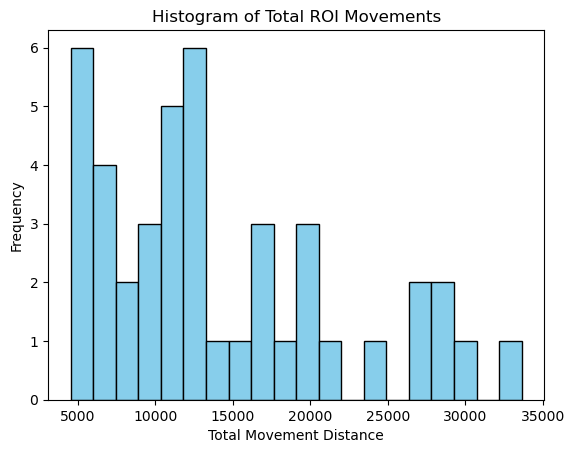

In [110]:
min_roi_count = min(len(frame_positions[i]) for i in range(76))
total_movements = [sum(calculate_distance(frame_positions[i][roi_index], frame_positions[i + 1][roi_index]) for i in range(75)) for roi_index in range(min_roi_count)]

# Plot the histogram
plt.hist(total_movements, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Total ROI Movements')
plt.xlabel('Total Movement Distance')
plt.ylabel('Frequency')
plt.show()

In [111]:
x =  image_data[frame_index, 0, 0, :, :]
y =  image_data[frame_index, 2, 0, :, :]

In [112]:
x = x.flatten()
y = y.flatten()

# Calculate means
mean_x = np.mean(x)
mean_y = np.mean(y)

# Calculate Pearson correlation coefficient
numerator = np.sum((x - mean_x) * (y - mean_y))
denominator = np.sqrt(np.sum((x - mean_x)**2) * np.sum((y - mean_y)**2))

pearson_corr = numerator / denominator

print("Pearson Correlation Coefficient:", pearson_corr)

Pearson Correlation Coefficient: 0.45579058631721797
